# Dynamic Attention Model (AM-D) Custom Execution

This notebook contains code as I explore and test the implementation created by Eremeev and Pustynnikov.

In [1]:
from attention_dynamic_model import AttentionDynamicModel
import tensorflow as tf
import time

2022-10-24 16:56:08.072286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
%env TF_GPU_ALLOCATOR=cuda_malloc_async

Num GPUs Available:  1
env: TF_GPU_ALLOCATOR=cuda_malloc_async


2022-10-24 16:56:38.899395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 16:56:39.935996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 16:56:39.936642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Documentation on the AttentionDynamicModel class

The AttentionDynamicModel class is the main model class that implements the AM-D model.

### The constructor

The constructor of the class will set up the basic attributes of the model as well as all the layers. For the encoder and decoder module, a separate class exists for the encoder, but the decoder is implemented inside this model.
```python
def __init__(self,
             embedding_dim, 
             n_encode_layers=2, 
             n_heads=8, 
             tanh_clipping=10): ...
```
| Parameter | Description |
|:---:|:---|
| embedding_dim | The cardinality of the output produced by the embedding projection. This is used to set define the input to the encoder module as well as for the input of the decoder module. |
| n_encode_layers | Number of encoder modules stacked |
| n_heads | Number of heads used by both encoder and decoder attention modules.|
| tanh_clipping | Value used for clipping the attention. |

In [3]:
# AM-D Model Parameters
embedding_dim   = 128
n_encode_layers = 2
n_heads         = 8
tanh_clipping   = 10

model_amd = AttentionDynamicModel(
    embedding_dim  =embedding_dim,
    n_encode_layers=n_encode_layers,
    n_heads        =n_heads,
    tanh_clipping  =tanh_clipping
)

2022-10-19 15:27:18.819641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 15:27:18.821073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 15:27:18.821815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 15:27:18.822406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

#### Setting the Decode Style

There are two types of decoding for AM-D:

1. Greedy
  - Greedy decoding will return the node with the highest probability from the decoder output.
2. Sampling
  - Sampling decoding will return a random node following the random distribution generated by the decoder.

In [4]:
model_amd.set_decode_type('sampling')

## Selecting Optimizer

We have to define an optimizer for the model. See keras' options for this. There are many types to choose from.

### Adam
```python
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```

In [5]:
from tensorflow.keras.optimizers import Adam

# Optimizer Parameters
learning_rate = 0.0001
beta_1        = 0.9
beta_2        = 0.999
epsilon       = 1e-07
amsgrad       = False
name          = "Adam"


optimizer = Adam(
    learning_rate=learning_rate,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
    amsgrad=amsgrad,
    name=name,
)

## Creating a Baseline for More Efficient Reinforcement Learning

The AM-D model uses a baseline to help improve the stability of learning. During regular reinforcement learning, it can be challenging to distinguish between actions when the reward obtained may vary based on the state the agent was found on. For example, a set of actions may produce a reward that could be different that the reward obtained starting in a different state that leads to the same end state. This means that the reward variance is high, and it can be hard to compare high reward actions when the initial state is variant. 

To solve this problem, a baseline can be used. In the past, baselines in RL would be a constant value that helps distinguish states based on a "neutral" state that provides information on whether an action is "better or worse." Variance in RL tends to be dependent on the state an agent is found, so we require a dynamic baseline that provides a "neutral" baseline to use for comparing the rewards and reach a referendum easier on what actions are better or worse. There are many different baselines, but for AM-D the best traines AM-D policy is used. If better actions are found that produce better reward, then, the baseline can help see these better actions, based on the best actions learned so far.

### Rollout Baseline

The Rollout baseline is a type of baseline that uses a ML model that produces the best learned actions so far. Whenever the learned model outperforms the baseline (statistically speaking with T-test) then, the baseline is replaced with the learned model.

__For the AM-D model, a warm up stage can be used for more stable convergance.__ The way this works is that a combination of exponential moving average baseline is used together with the rolling baseline. At the very begining of learning, the policy for the rollout baseline may be too bad to give meaningful baseline costs. To solve this, we can first rely on exponential moving average that utilizes the mean cost obtained by the training model and the average cost is over time is updated by weighting recently-obtained costs higher than previous ones. This also helps in getting through the initial "row" of bad costs obtained by exploration. The Exponential Moving Average (EMA) equation is the following:

$M \leftarrow \beta M + (1-\beta) L(\pi)$

Where $M$ is the moving average and $\beta$ is the weight factor on the importance of previous obtained costs with respect to recent ones. As $\beta$ approaches 0, recent costs are more important and previous costs are forgoten faster. as $\beta$ apptoaches 1.0, previous costs are not as forgoten and remain important to recent average cost. Finding a good balance is important because low $\beta$ will make the average cost be too unstable but high $\beta$ will make the cost depend too much on early outlier costs that may make the cost unstable.

The output cost used for the baseline learning will be a weighted combination of both EMA and rollout baseline. More precisely:

$L(baseline) \leftarrow \alpha L(\pi_g) + (1 - \alpha) M$

Where $\pi_g$ is the rollout baseline used by the algorithm; $\alpha = \frac{epoch + 1}{wp\_n\_epochs}$ is an dynamically-increasing constant from $0.0$ up to $1.0$. $\alpha$ is not allowed to pass $1.0$, and when it does, warm up is deemed complete and only the baseline cost is used.

```python
def __init__(self, 
             model, 
             filename,
             from_checkpoint=False,
             path_to_checkpoint=None,
             wp_n_epochs=1,
             epoch=0,
             num_samples=10000,
             warmup_exp_beta=0.8,
             embedding_dim=128,
             graph_size=20
             ): ...
```

| Parameter           | Description |
| :---:               | :--- |
| model               | Initial ML model to use as baseline |
| filename            | Suffix for checkpoint name for the model (Keras). Model name template is `{path_to_checkpoint}/baseline_checkpoint_epoch_{epoch}_{filename}.h5`|
| from_checkpoint     | Flag to use a saved checkpoint following the suffix provided. |
| path_to_checkpoint  | Directory where to save baseline |
| wp_n_epochs         | Number of warm up epochs |
| epoch               | Starting epoch number |
| num_samples         | Size of dataset generated for baseline. Used when deciding whether current model is statistically better than the baseline. |
| warmup_exp_beta     | weight used during warm up. Balances incorporation of Exponential Moving Average and Rollout Baselines |
| embedding_dim       | used for loading up model. |
| graph_size          | Used for loading up model. |

In [6]:
from reinforce_baseline import RolloutBaseline
from time import strftime, gmtime

model              = model_amd
graph_size         = 20
filename           = 'VRP_{}_{}'.format(graph_size, strftime("%Y-%m-%d", gmtime()))
from_checkpoint    = False
path_to_checkpoint = None
wp_n_epochs        = 5
epoch              = 0
num_samples        = 10_000
warmup_exp_beta    = 0.8
embedding_dim      = embedding_dim


baseline = RolloutBaseline(model             = model,
                           filename          = filename,
                           from_checkpoint   = from_checkpoint,
                           path_to_checkpoint= path_to_checkpoint,
                           wp_n_epochs       = wp_n_epochs,
                           epoch             = epoch,
                           num_samples       = num_samples,
                           embedding_dim     = embedding_dim,
                           graph_size        = graph_size
                           )

Evaluating baseline model on baseline dataset (epoch = 0)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:21<00:00,  2.11s/it]


## Creating Problem Dataset

Dataset generation is provided by the `utils.py` module. The recommended function to generate data is `create_data_on_disk`:

```python
def create_data_on_disk(
    graph_size, 
    num_samples, 
    is_save=True, 
    filename=None, 
    is_return=False, 
    seed=1234): ...

```

| Parameter | Description|
| :---:     | :---       |
| graph_size  | Number of nodes to generate |
| num_samples | Size of dataset |
| is_save     | Flag for saving to disk |
| filename    | Suffix of dataset: 'Validation\_dataset\_{filename}.pkl' |
| is_return   | Whether to return dataset or not |
| seed        | Seed for generation |

Note that the data generated will use the TensorFlow API for datasets.

In [7]:
from utils import create_data_on_disk

graph_size  = graph_size
num_samples = 10_000
is_save     = True
filename    = filename
is_return   = True
seed        = 42

validation_dataset = create_data_on_disk(graph_size =graph_size,
                                         num_samples=num_samples,
                                         is_save    =is_save,
                                         filename   =filename,
                                         is_return  =is_return,
                                         seed       =seed)

### Vizualization of output data

Bellow we can appreciate the data generated with the TF dataset API. Also, a plot of the data can be seen in the graph bellow.

#### Format of Data Generated

The data generated uses Tensorflow's dataset API. This means that the data is generated in a batch-to-batch generation format. To access the data directly, use `next(data.batch(n).as_numpy_iterator)`. The data generated has the following structure:

```
batched_data[data type][batch's sample][xy data]
```

Here, `data type` represents the type of node that it is dealt with. In the case of the VRP data generator, this means whether we wish to look at the requesting/space nodes (value 1) or if we want to see the initial depot that the agents starts at (value 0). The `batch's sample` is just an index within the batch generated. Finally, `xy data` provides the type of node data to see. 0 is for x, 1 is for y.

In [8]:
import pandas as pd
import seaborn as sns

# Grab first 6,000 datapoints. 6,000 is some random number.
gen_data = next(validation_dataset.batch(6_000).as_numpy_iterator())

# We select the first sample from the generated batch (first out of 6,000)
sample   = 0

# We collect all other nodes. Note: first index of gen_data [0] -> depot node, [1] -> other nodes
graph    = pd.DataFrame(gen_data[1][sample], columns=['x', 'y'])

# We collect the depot node. Add a label to identify it in table.
depot = {
    'x': gen_data[0][sample][0], 
    'y': gen_data[0][sample][1], 
    'type': 'depot'
}
# Label all other datapoints as nodes and add the already-labeled depot node
graph = graph.assign(type='node').append(depot, ignore_index=True)

/tmp/ipykernel_75366/106837068.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.assign(type='node').append(goal, ignore_index=True)


,x,y,type
0,0.090576,0.105941,node
1,0.672503,0.656092,node
2,0.402797,0.798440,node
3,0.893440,0.426028,node
4,0.260078,0.359273,node
5,0.652982,0.425485,node
6,0.080519,0.855694,node
7,0.147657,0.004048,node
8,0.521012,0.173180,node
9,0.042330,0.255430,node


In [ ]:
graph

<AxesSubplot: xlabel='x', ylabel='y'>

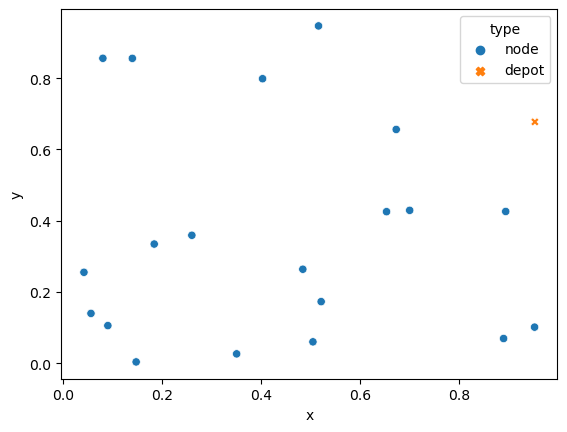

In [9]:
sns.scatterplot(data=graph, x='x', y='y', hue='type', style='type')

### Training the Model

The developers provide a training function for orchestrating the training and rollout process of training.

```python
def train_model(optimizer,
                model_tf,
                baseline,
                validation_dataset,
                samples = 1280000,
                batch = 128,
                val_batch_size = 1000,
                start_epoch = 0,
                end_epoch = 5,
                from_checkpoint = False,
                grad_norm_clipping = 1.0,
                batch_verbose = 1000,
                graph_size = 20,
                filename = None
                ): ...
```

| Parameter          | Description |
| :----------------: | :---------- |
| optimizer          | Optimizer to be used for training |
| model_tf           | Training model to use             |
| baseline           | Initial baseline                  |
| validation_dataset | Generated dataset for validation (used at the end) |
| samples            | Number of samples to use for each learning epoch |
| batch              | Size of batches for learning      |
| val_batch_size     | Number of batches to use for validation (averaged out at the end for final score)|
| start_epoch        | Initial epoch configuration       |
| end_epoch          | Last epoch                        |
| from_checkpoint    | Flag for loading checkpoint       |
| grad_norm_clipping | Clipping/rescaling of gradients   |
| batch_verbose      | Verbosity of output               |
| graph_size         | Number of nodes for graph generated |
| filename           | Suffix of saved model: `VRP_{graph_size}_{date}` |

In [10]:
from train import train_model

# Parameters
optimizer          = optimizer
model_tf           = model
baseline           = baseline
validation_dataset = validation_dataset
samples            =  52_000 # Paper: 1_280_000
batch              = 32
val_batch_size     = 1_000 
start_epoch        = 0
end_epoch          = 50
from_checkpoint    = False
grad_norm_clipping = 1.0
batch_verbose      = 1_000
graph_size         = graph_size
filename           = filename

# Used for timing
start_time = time.time()
print(start_time)

# Train...
train_model(optimizer =optimizer,
            model_tf = model_tf,
            baseline = baseline,
            validation_dataset = validation_dataset,
            samples = samples,
            batch = batch,
            val_batch_size = val_batch_size,
            start_epoch = start_epoch,
            end_epoch = end_epoch,
            from_checkpoint = from_checkpoint,
            grad_norm_clipping = grad_norm_clipping,
            batch_verbose = batch_verbose,
            graph_size = graph_size,
            filename = filename
            )
print(time.time() - start_time )

1666211299.4284105
Current decode type: sampling


batch calculation at epoch 0: 1it [00:02,  2.19s/it]

grad_global_norm = 8.752344131469727, clipped_norm = 0.9999999403953552
Epoch 0 (batch = 0): Loss: 0.4247629642486572: Cost: 13.520952224731445


batch calculation at epoch 0: 1001it [17:52,  1.03s/it]

grad_global_norm = 10.049118995666504, clipped_norm = 1.0
Epoch 0 (batch = 1000): Loss: 0.12831465899944305: Cost: 9.994102478027344


batch calculation at epoch 0: 1625it [28:52,  1.07s/it]


Evaluating candidate model on baseline dataset (callback epoch = 0)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch 0 candidate mean 8.094402313232422, baseline epoch 0 mean 13.717153549194336, difference -5.622751235961914
p-value: 0.0
Update baseline
Evaluating baseline model on baseline dataset (epoch = 0)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.66it/s]


alpha was updated to 0.2


Rollout greedy execution: 100%|█████████████████| 10/10 [00:05<00:00,  1.67it/s]


Validation score: 8.113699913024902
2022-10-19 15:58:16 Epoch 0: Loss: -0.05598825216293335: Cost: 9.48063850402832
Current decode type: sampling


batch calculation at epoch 1: 1it [00:01,  1.58s/it]

grad_global_norm = 13.598526954650879, clipped_norm = 1.0000001192092896
Epoch 1 (batch = 0): Loss: -0.7262731790542603: Cost: 8.3829345703125


batch calculation at epoch 1: 1001it [25:27,  1.51s/it]

grad_global_norm = 16.113672256469727, clipped_norm = 1.0
Epoch 1 (batch = 1000): Loss: -0.3159732222557068: Cost: 8.044578552246094


batch calculation at epoch 1: 1625it [41:16,  1.52s/it]


Evaluating candidate model on baseline dataset (callback epoch = 1)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 1 candidate mean 7.510475158691406, baseline epoch 1 mean 8.135576248168945, difference -0.6251010894775391
p-value: 0.0
Update baseline
Evaluating baseline model on baseline dataset (epoch = 1)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.58it/s]


alpha was updated to 0.4


Rollout greedy execution: 100%|█████████████████| 10/10 [00:10<00:00,  1.02s/it]


Validation score: 7.506999969482422
2022-10-19 16:40:38 Epoch 1: Loss: -0.11084447056055069: Cost: 7.942144393920898
Current decode type: sampling


batch calculation at epoch 2: 1it [00:01,  1.47s/it]

grad_global_norm = 11.935769081115723, clipped_norm = 0.9999999403953552
Epoch 2 (batch = 0): Loss: -1.5577688217163086: Cost: 7.918816089630127


batch calculation at epoch 2: 1001it [26:37,  1.77s/it]

grad_global_norm = 12.061907768249512, clipped_norm = 1.0
Epoch 2 (batch = 1000): Loss: -0.3782106935977936: Cost: 7.543488025665283


batch calculation at epoch 2: 1625it [43:59,  1.62s/it]


Evaluating candidate model on baseline dataset (callback epoch = 2)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 2 candidate mean 7.255475044250488, baseline epoch 2 mean 7.508060932159424, difference -0.25258588790893555
p-value: 6.410203039898151e-285
Update baseline
Evaluating baseline model on baseline dataset (epoch = 2)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.57it/s]


alpha was updated to 0.6


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.50it/s]


Validation score: 7.246200084686279
2022-10-19 17:25:40 Epoch 2: Loss: -0.2450256198644638: Cost: 7.486406326293945
Current decode type: sampling


batch calculation at epoch 3: 1it [00:01,  1.54s/it]

grad_global_norm = 11.206875801086426, clipped_norm = 0.9999999403953552
Epoch 3 (batch = 0): Loss: -0.7285658121109009: Cost: 7.298762321472168


batch calculation at epoch 3: 1001it [28:00,  1.69s/it]

grad_global_norm = 13.638163566589355, clipped_norm = 0.9999999403953552
Epoch 3 (batch = 1000): Loss: -0.4768742620944977: Cost: 7.290483474731445


batch calculation at epoch 3: 1625it [45:54,  1.70s/it]


Evaluating candidate model on baseline dataset (callback epoch = 3)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 3 candidate mean 7.113739013671875, baseline epoch 3 mean 7.257171154022217, difference -0.1434321403503418
p-value: 3.837320383133212e-129
Update baseline
Evaluating baseline model on baseline dataset (epoch = 3)


Rollout greedy execution: 100%|█████████████████| 10/10 [00:07<00:00,  1.42it/s]


alpha was updated to 0.8


Rollout greedy execution: 100%|█████████████████| 10/10 [00:06<00:00,  1.43it/s]


Validation score: 7.110099792480469
2022-10-19 18:12:38 Epoch 3: Loss: -0.4190031588077545: Cost: 7.281337261199951
Current decode type: sampling


batch calculation at epoch 4: 1it [00:01,  1.62s/it]

grad_global_norm = 11.672294616699219, clipped_norm = 1.0
Epoch 4 (batch = 0): Loss: -1.3833853006362915: Cost: 7.638968467712402


batch calculation at epoch 4: 183it [05:34,  1.83s/it]


KeyboardInterrupt: 

## Saving a Model

Since AM-D is a custom model, we can only save the weights on their own. Loading them requires creating a new AM-D model, set it up, and load the weights:

```python
loaded_model = AttentionDynamicModel(
    embedding_dim  =embedding_dim,
    n_encode_layers=n_encode_layers,
    n_heads        =n_heads,
    tanh_clipping  =tanh_clipping
)

# See Keras' API. the type *.ckp can be anything.
loaded_model.load_weights('some_folder/some_checkpoint.ckp')

# Don't forger to set the decoding type! Otherwise you get an error when trying to do inference!
loaded_model.set_decode_type('greedy')
```

In [11]:
nodes     = 20
date      = 'oct_19'
_iter     = end_epoch - start_epoch
n_batches = samples
batch_size = batch

model_tf.save_weights(f"checkpoints/AM-D_{date}_{nodes}_nodes_{_iter}_iter_{n_batches}_batches_{batch_size}_batch_size.ckp")